In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli
import matplotlib as mpl

In [2]:
# Generates rewards matrix of size (2, ktrials, Nflies, precision, precision, precision)
# rb varies, and ry is a multiple of rb (the double if reward_quotient is set at 2)

def create_rewards(ktrials,Nflies,precision):
    r=np.random.randint(0,2,size=(ktrials,Nflies,precision,precision,precision))
    
    rb=coeff_r*r
    ry=reward_quotient*rb 
    
    rewards=np.asarray(np.empty((2,ktrials,Nflies,precision,precision,precision)))
    rewards[0]=rb
    rewards[1]=ry
    return (rewards)

In [3]:
# Generates choice array  of size (2,Nflies,precision,precision,precision)

def choice (mb,my):
    Py = np.exp(beta * my) / (np.exp(beta * my) + np.exp(beta * mb))
        
    cy = bernoulli.rvs(Py)
    cb = - cy +1
    return [cb,cy]

In [4]:
# Returns the estimated and effective rewards, and the energy spent.
# Respectively 2 arrays of size (Nflies,precision,precision,precision), an array of size (ktrials,Nflies,precision,precision,precision) and an array of size (Nflies,precision,precision,precision) 

def r_E_calcul(cb,cy,r_E_variables,rewards,i,lambda_ARM):
    r_E_variables["expected_rb"] = (1 - lambda_r * cb) * r_E_variables["expected_rb"] + lambda_r*rewards[0][i] * cb
    r_E_variables["expected_ry"] = (1 - lambda_r * cy) * r_E_variables["expected_ry"] + lambda_r*rewards[1][i] * cy
    
    
    r_E_variables["E"]=np.where(lambda_ARM == 0,r_E_variables["E"] + (abs(r_E_variables["dmb"]) + abs(r_E_variables["dmy"]))*energy_factor,0)
    
    r_E_variables["reward_received"][i] = rewards[0][i]*cb+rewards[1][i]*cy
      
    return[r_E_variables["expected_rb"],r_E_variables["expected_ry"],r_E_variables["reward_received"], r_E_variables["E"]]

In [5]:
# Generates an array of the mean reward received and energy spent, of size (2, precision, precision)

def sum_reward_energy(rewards, beta, lambda_r,model):
    m_max=1
    x=1
    
    eps = np.linspace(np.zeros((precision,precision)),np.ones((precision,precision)),precision)
    
    mb = np.zeros((Nflies,precision,precision,precision))
    my = np.zeros((Nflies,precision,precision,precision))
    
    r_E_variables = { "expected_rb" : np.zeros((Nflies,precision,precision,precision)),
                    "expected_ry" : np.zeros((Nflies,precision,precision,precision)),
                    "reward_received" : np.empty((ktrials,Nflies,precision,precision,precision)),
                    "E" : np.zeros((Nflies,precision,precision,precision))}
    
    reward_E = np.empty((2,precision,precision))
    
    for i in range (ktrials) :
        
        [cb,cy]=choice(mb,my)
        
        lambda_ARM= np.zeros((Nflies,precision,precision,precision))
        
        if model=="ARM":
            lambda_ARM = 1/2.5
        else :
            lambda_ARM[np.where((rewards[0][i] - r_E_variables["expected_rb"])*cb + abs(rewards[1][i] - r_E_variables["expected_ry"])*cy < threshold)] = 1/2.5
        
        mb -= mb * lambda_ARM
        r_E_variables["dmb"] = cb * eps * (rewards[0][i] - r_E_variables["expected_rb"]) * (x - mb/m_max)
        
        b_positive_correction=np.where(mb + r_E_variables["dmb"] < 0)
        r_E_variables["dmb"][b_positive_correction]= 0 - mb[b_positive_correction]
        
        b_max_correction=np.where(mb + r_E_variables["dmb"] > m_max)
        r_E_variables["dmb"][b_max_correction]= m_max - mb[b_max_correction]
        
        mb += r_E_variables["dmb"]
        
        my -= my * lambda_ARM
        r_E_variables["dmy"] = cy * eps * (rewards[1][i] - r_E_variables["expected_ry"]) * (x - my/m_max)
        
        y_positive_correction=np.where(my + r_E_variables["dmy"] < 0)
        r_E_variables["dmy"][y_positive_correction]= 0 - my[y_positive_correction]
        
        y_max_correction=np.where(my + r_E_variables["dmy"] > m_max)
        r_E_variables["dmy"][y_max_correction]= m_max - my[y_max_correction]
        
        my += r_E_variables["dmy"]
    
        
        [r_E_variables["expected_rb"],r_E_variables["expected_ry"],r_E_variables["reward_received"], r_E_variables["E"]]=r_E_calcul(cb,cy,r_E_variables,rewards,i,lambda_ARM)
    reward_E[0] = sum(sum(sum(r_E_variables["reward_received"])))/(Nflies*precision)
    reward_E[1] = sum(sum(r_E_variables["E"]))/(Nflies*precision)
    return reward_E


In [6]:
#Parameters settings
Nflies = 100
ktrials = 200
precision = 41
lambda_r=0.1
beta=7
coeff_r =np.empty((precision,precision,precision))
for i in range(precision):
    coeff_r[i]=np.linspace(np.zeros(precision),np.ones(precision)*10,precision)
reward_quotient = 2
energy_factor=30
threshold = np.linspace(np.zeros((precision,precision)),np.ones((precision,precision))*20,precision).T

In [7]:
# Generates an array of the mean reward received and energy spent, using LTM when above the threshold, and using ARM only, of size (2,2,precision, precision)
all_reward_E = np.empty((2,2,precision,precision))
all_reward_E[0,] = sum_reward_energy(create_rewards(ktrials,Nflies,precision), beta, lambda_r, "Threshold")
all_reward_E[1] = sum_reward_energy(create_rewards(ktrials,Nflies,precision), beta, lambda_r,"ARM")


In [8]:
# Generates an array of the the mean performance
# Size (2,precision, precision)
mean_random_r=150*sum(coeff_r)/precision
max_r=200*sum(coeff_r)/precision
perf = np.empty((2,precision,precision))
perf[0] = (all_reward_E[0,0] - mean_random_r) / (max_r - mean_random_r)
perf[1] = (all_reward_E[1,0] - mean_random_r) / (max_r - mean_random_r)

/var/folders/zf/tw6675q13m14kfmvcjj4h4s40000gn/T/ipykernel_5338/1068746967.py:6: RuntimeWarning: invalid value encountered in true_divide
  perf[0] = (all_reward_E[0,0] - mean_random_r) / (max_r - mean_random_r)
/var/folders/zf/tw6675q13m14kfmvcjj4h4s40000gn/T/ipykernel_5338/1068746967.py:7: RuntimeWarning: invalid value encountered in true_divide
  perf[1] = (all_reward_E[1,0] - mean_random_r) / (max_r - mean_random_r)


In [9]:
# Generates an array of the energy gain of the threshold model
# Size (precision, precision)
Threshold_E_gain = all_reward_E[0,0] - all_reward_E[0,1]- all_reward_E[1,0]

In [10]:
# Plots the chosen parameter as a fonction of the threshold and the mean reward which would be received without learning

def Plot(P,Title,norm):
    plt.colorbar(plt.imshow(P, origin="lower",cmap="jet",norm=norm))
    plt.xlabel('Threshold')
    plt.ylabel('Mean reward at random')
    ticks=[0,8,16,24,32,40]
    threshold_label=["0", "4", "8", "12", "16", "20"]
    plt.xticks(ticks, threshold_label)
    r_label=["0", "300", "600", "900", "1200", "1500"]
    plt.yticks(ticks, r_label)
    plt.title(Title)

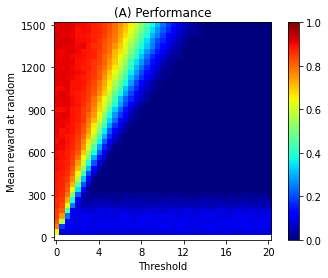

In [11]:
#Plot of the performance for each threshold and mean reward at random value
Plot(perf[0],"(A) Performance",mpl.colors.Normalize(vmin=0, vmax=1))

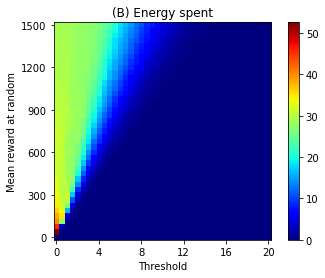

In [12]:
#Plot of the energy spent for each threshold and mean reward at random value
Plot(all_reward_E[0,1],"(B) Energy spent",None)

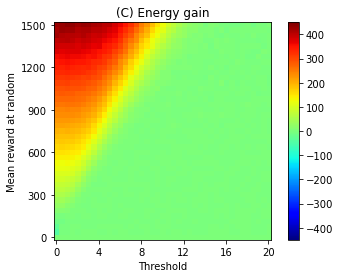

In [13]:
#Plot of the energy gain of the model using LTM when above the threshold
Plot(Threshold_E_gain,"(C) Energy gain",mpl.colors.Normalize(vmin=-450, vmax=450))

Text(0.5, 1.0, '(D) Best threshold value for each mean reward at random')

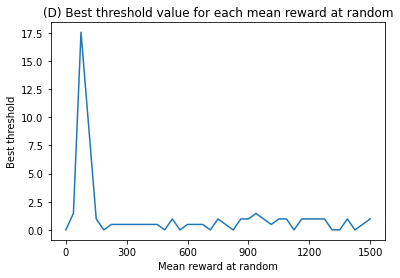

In [14]:
#Plot of the threshold value for which (r with threshold - r with ARM - energy spent) is highest for each epsilon value
best_threshold=np.argmax(Threshold_E_gain,axis=1)*20/precision
plt.plot(best_threshold)
plt.xlabel("Mean reward at random")
plt.ylabel("Best threshold")
ticks = [0,8,16,24,32,40]
r_label=["0", "300", "600", "900", "1200", "1500"]
plt.xticks(ticks, r_label)
plt.title("(D) Best threshold value for each mean reward at random")